# Predicting housing prices using linear regression

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

In this project we seek to predict housing prices given data of residential homes in Ames, Iowa. We will first build a simple linear regression model using OLS, then we will iterate on that model until we get a satisfactory result. Although it is not the only approach, OLS is by far the most common method of estimating linear regression models. 

### Setup and data clean

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0

In [ ]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

Before building our initial model we need to do some data cleaning. There are also a lot of features here, so we'll want to choose a few that we think will perform the best.

In [ ]:
# collect numeric columns, show thier correlation with sale price

num_cols = house_df.select_dtypes(['int64', 'float64']).columns
house_df[num_cols].iloc[:,1:].corr().loc[:,"saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64

### Initial model

Since we are only building a basic model with plans to improve it later, I will simply pick the top 5 features, only omitting features with extreme collinearity such as in the case of 'garagecars' and 'garagearea' columns.

In [ ]:
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'firstflrsf']]
y = house_df.saleprice

In [ ]:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     928.8
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:36:22   Log-Likelihood:                -17497.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.03e+05   4901.609    -21.006      

In [ ]:
predictions = model.predict(X)
print(predictions)

0       206542.225230
1       178079.953333
2       212180.326267
3       223758.871513
4       280418.133862
            ...      
1455    183416.835622
1456    229657.221721
1457    226906.240434
1458    121218.153143
1459    135454.008782
Length: 1460, dtype: float64


### Assumptions of linear regression

There are six assumptions of linear regression.

1. linearity of models in their coefficients
2. the error term should be zero on average
3. homoscedasticity
4. low multicollinearity
5. error terms should be uncorrelated with one another
6. features shouldn't be correlated with the errors

We also want to check the normality of the errors...While not required for OLS regression, in order to measure the statistical significance of our estimated coefficients, the error terms must be normally distributed.


#### Linearity of coefficients

Since OLS determines the coefficients and takes into account the assumption of linearity between them, we do not need to worry about this one.

#### Error term 0 on average

As long as we include a constant in our model, we should not have to worry about this assumption as the constant will force the error terms to be 0 on average. As we can see below, this is the case with our model and the error term is effectively zero.

In [ ]:
errors = y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 7.3233510093278675e-09


#### Homoscedasticity

A model is **homoscedastic** when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. In other words, the error variance shouldn't systematically change across observations. When this assumption is not met, we are dealing with **heteroscedasticity**.

There are several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms. We will use **Bartlett** and **Levene** tests.

The null hypothesis of these tests is that the errors are homoscedastic.

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 466.29 and p value is 2.06e-103
Levene test statistic value is 450.721 and p value is 3.92e-93


We can see that the p-value of both tests is less than .05, meaning we reject the null hypothesis. This means our errors are heteroscedastic. 

Even though our model suffers from the heteroscedasticity, the estimated coefficients are still valid (more formally, they are consistent but we will not discuss consistency of the estimations now). The only problem is with the reliability of some statistical tests like t-test. Heteroscedasticity may also make some estimated coefficients seem to be statistically insignificant. 

#### Low multicollinearity

Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. When features are correlated, they may both explain the same pattern of variance in the outcome. 

To detect multicollinearity, we can simply look at the correlation matrix of the features. Multicollinearity can be fixed by PCA or by discarding some of the correlated features.

#### Error terms uncorrelated with each other

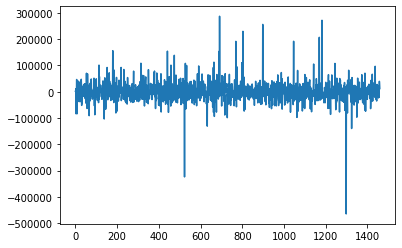

In [ ]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

Another way to look at correlations between errors is to use the autocorrelation function. This function computes the correlation of a variable with itself. In our case, the order of the errors are the orders of the observations.

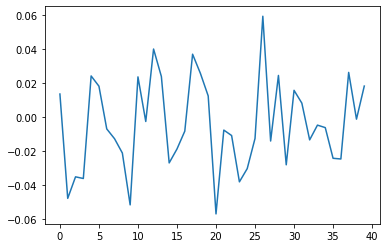

In [ ]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of our medical costs model is indeed very low (ranging between -0.06 and 0.06).

#### Features shouldn't be correlated with the errors

Last but definitely not least, and arguably the most important assumption: explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the **exogeneity**.

Violations of the exogeneity assumption may have several sources. Common causes are omitted variables and simultaneous causation between independent variables and the target. If the problem stems from simultaneous causation then we need to apply some advanced techniques to solve for the issue but this is beyond the scope of this project.

#### Normality of errors


Although it is not an assumption of OLS, normality of errors is still required in order to measure the statistical significance of our estimated coefficients.

More often than not, non-normally distributed errors stem from omitted variables. Including the omitted relevant features to the model may help fix the issue. Sometimes, transforming the dependent variable also helps.

There are various ways to check for normality of error terms. An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:

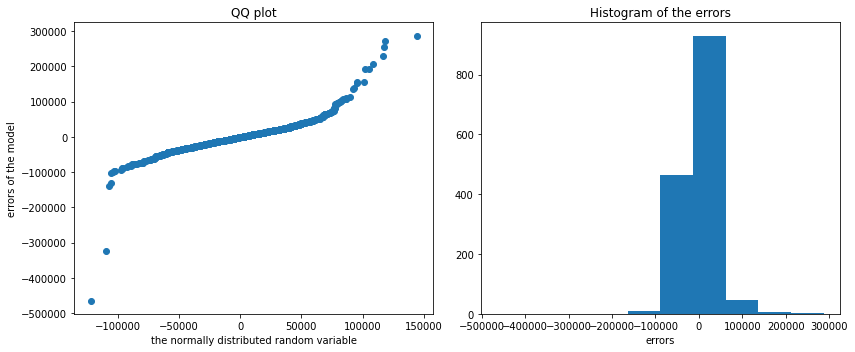

In [ ]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

While visualizations give us a first impression about normality, the best way to learn about this is to apply formal statistical tests. To this end, we use two of them from scipy's stats module: **Jarque Bera** and **normal** tests. The null hypothesis of both tests is that the errors are normally distributed.

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 35788.40470560869 and p value is 0.0
Normality test statistics is 417.21030061805965 and p value is 2.5347452868339113e-91


The p-values of both tests indicate that our errors are not normally distributed.

### Interpreting estimated coefficients and evaluating performance

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     928.8
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:36:22   Log-Likelihood:                -17497.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.03e+05   4901.609    -21.006      

All variables are statistically significant. We know this because the P-values are less than .05. According to our results:

- 1 point increase in 'overallqual' results in a \$23960 increase in sale price
- 1 point increase in 'grlivarea' results in a \$43.30 increase in sale price
- 1 point increase in 'garagecars' results in a \$18190 increase in sale price
- 1 point increse in 'totalbsmtsf' results in a \$25 increase in sale price
- 1 point increase in 'firstflsf' results in \$11.66 increase in sale price.

Now let's look assess the goodness of fit using F-test, R-squared (adjusted R-squared), AIC, and BIC.

The F-statistic p-value is 0, this indicattes that our model is useful in explaining sale price. However, F-tests don't quantify how much information our model contribures. This requires R-squared.

Our R-sqaured and adjusted R-squared were .762 and .761 respectively. R-sqaured represents the propotion of the variance for a dependent variable that is explained by an independent variable in a regression model. For example, if the R2 of a model is 0.50, then approximately half of the observed variation can be explained by the model's inputs. Adjusted R-squared does the same job as R-squared, but it is adjusted according to the number of features included in the model. This is why it's always safer to look at this value over the normal R-squared. 

Too high of an R-squared value may be a sign of overfitting. Luckily we have other ways to check for that.

The AIC and BIC were 35010 and 35040. 

For both AIC and BIC, the lower the value the better. Hence, we choose the model with the lowest AIC or BIC value. Although we can use either of the two criteria, AIC is usually criticized for its tendency to overfit. In contrast, BIC penalizes the number of parameters more severely than AIC and hence favors more parsimonious models (that is, models with fewer parameters).

### Second model

Let's see if we can improve our model. Specifically I want to look at some of the non-numeric features of our dataset and one-hot encode them before adding them to our model.

In [ ]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

The 'mszoning' column seems like it could be important. Let's create dummy values and add it to our model.

In [ ]:
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)

In [ ]:
dummy_col_names = list(pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True).columns)

Recreate our model.

In [ ]:
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'firstflrsf'] + dummy_col_names]
y = house_df.saleprice


In [ ]:
X = sm.add_constant(X)

model2 = sm.OLS(y, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     535.8
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:36:23   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1450   BIC:                         3.502e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.176e+05   1.25e+04     -9.377      

Comparing this to our old model, it seems to have marginally improved!

We also notice from the p-values that all the zoning features other than 'mszoning_RL' are statistically insignificant. We will remove those to further improve our model. 'firstflrsf' can also be dropped. I am going against the model's suggestions here and keeping 'mszoning_FV'. We'll see how it plays out.

Since we have improved our model, we will now use it to make predicitions. we'll do this with a test train split.

In [ ]:
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_RL', 'mszoning_FV']]
y = house_df.saleprice

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=20
)

Remember to add constant.

In [ ]:
X_train = sm.add_constant(X_train)

Now we train our model.

In [ ]:
model3 = sm.OLS(y_train, X_train)
model3_results = model3.fit()

print(model3_results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     623.6
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:36:23   Log-Likelihood:                -14005.
No. Observations:                1168   AIC:                         2.802e+04
Df Residuals:                    1161   BIC:                         2.806e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.075e+05   5396.244    -19.918      

This model has a lower adj. r-squared than our second iteration. However this could actually be a sign of improvement, as the second model might have been overfit. The AIC and BIC are significantly lower than the second iteration. This indicates that this model performs better.

Let's plot our model and look at some evaluation metrics.

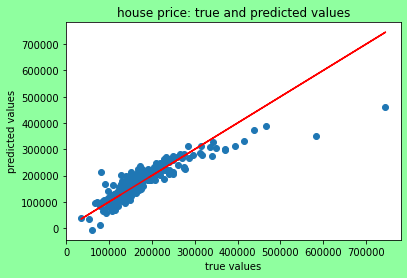

Mean absolute error of the prediction is: 23155.6589736649
Mean squared error of the prediction is: 1240194997.1425798
Root mean squared error of the prediction is: 35216.4023878445
Mean absolute percentage error of the prediction is: 14.187155820488817


In [ ]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = model3_results.predict(X_test)

fig = plt.figure()
fig.patch.set_facecolor('xkcd:mint green')
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("house price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



The model seems to predict well for lower values, but under-predicts the most expensive houses.

When we were evaluating the training performance of a linear regression model, we used metrics like R-squared and adjusted R-squared. R-squared measures the ratio of variance in the target variable that is explained by the model. However, when we are making predictions we care more about how close our predictions are to the target rather than the variance in the target variable. This means that we usually use metrics other than R-squared to gauge how good our predictions are.





*   **Mean absolute error (MAE)** is defined as the average of the absolute values of the errors between the true values and the predicted values
*   **Mean squared error (MSE)** is defined as the average of the squared errors between the true values and the predicted values
* **Root mean squared error (RMSE)** is defined as the square root of the MSE
* **Mean absolute percentage error (MAPE)** is defined as the average of the ratio of the absolute values of the errors to the true values





Although these are different metrics, they are essentially using the difference between what we know to be correct medical cost for a person and predicted medical cost from the model. These errors are then summed up for an overall error score.

We can use any one of the above metrics. But there are some important points to note about them:

* Lower values are desirable for all four metrics. The lower the value, the better the performance of the model.
* MAE, MSE, and RMSE are in the unit of the target variable but MAPE is unitless. So MAE, MSE, and RMSE are only useful if we compare different models that have the same target variable.
* MSE and RMSE penalize large errors more than the MAE and MAPE do. This means that MSE and RMSE are more useful when high error values are undesirable.
* For target values very close to zero, MAPE may provide a problematic picture of the performance as the ratio may go to very high values, and this may distort the average. It can also give division by zero errors if some values of the target are zero!

Thus far we have been using OLS - Ordinary Least Squares to fit our models. However we may be able to improve our model using different types of regression. **Ridge**, **Lasso**, and **ElasticNet** are three examples that I will implement here.

In [ ]:
models = {'OLS': linear_model.LinearRegression(),
          'Lasso': linear_model.Lasso(),
          'Ridge': linear_model.Ridge(),
          'ElasticNet': linear_model.ElasticNet(),}


This function will test all 3 models.

In [ ]:
def test(models, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = .2, random_state = 20
            )
            r2_test.append(metrics.r2_score(
                y_test, models[i].fit(X_train, y_train).predict(X_test))
            )
            r2_train.append(metrics.r2_score(
                y_train, models[i].fit(X_train,y_train).predict(X_train))
            )
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [ ]:
test(models)

,OLS,Lasso,Ridge,ElasticNet
0,0.763183,0.763183,0.763181,0.741734
1,0.785531,0.785534,0.785596,0.790065


With 0 representing the training data, and 1 representing the test data, it looks like ElasticNet performs the best. ElasticNet is a combination of both Lasso (L1 regularization) and Ridge (L2 Regularization).

We can improve on these models by tuning the hyperparameters.

In [ ]:
alphas = [np.power(10.0,p) for p in np.arange(-10,5,1)]

I will use the CV variants of these models to iterate across different alpha values using 5 folds.

In [ ]:
models = {'OLS': linear_model.LinearRegression(),
          'LassoCV': linear_model.LassoCV(alphas=alphas, cv=5),
          'RidgeCV': linear_model.RidgeCV(alphas=alphas, cv=5),
          'ElasticNetCV': linear_model.ElasticNetCV(alphas=alphas, cv=5),}


Running this test function again may take a few minutes.

In [ ]:
%time
test(models)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


,OLS,LassoCV,RidgeCV,ElasticNetCV
0,0.763183,0.763182,0.763181,0.763140
1,0.785531,0.785559,0.785596,0.785885


In this case, tuning the hyperparameters didn't make much of a difference. It was also very computation heavy.

Let's compare our first model with our final ElasticNetCV. We will recreate them both and then plot them.

In [ ]:
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'firstflrsf']]
y = house_df.saleprice

X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = .2, random_state = 20
                )

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_initial = sm.OLS(y_train, X_train).fit()
y_preds = model_initial.predict(X_test)

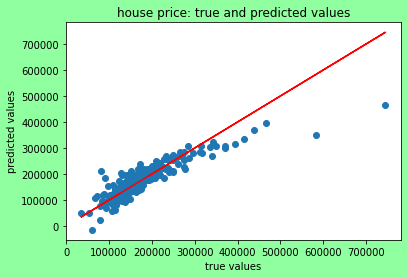

Mean absolute error of the prediction is: 23098.39117074326
Mean squared error of the prediction is: 1255866581.5673957
Root mean squared error of the prediction is: 35438.20793391499
Mean absolute percentage error of the prediction is: 14.352751414598778


In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:mint green')
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("house price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [ ]:
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_RL', 'mszoning_FV']]
y = house_df.saleprice

X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = .2, random_state = 20
                )

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_final = sm.OLS(y_train, X_train).fit()
y_preds = model_final.predict(X_test)

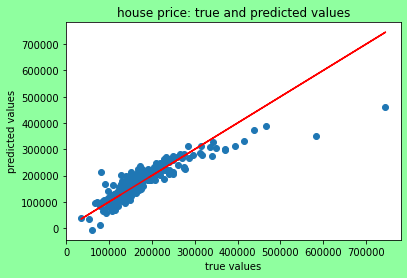

Mean absolute error of the prediction is: 23155.6589736649
Mean squared error of the prediction is: 1240194997.1425798
Root mean squared error of the prediction is: 35216.4023878445
Mean absolute percentage error of the prediction is: 14.187155820488817


In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:mint green')
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("house price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



Both plots are pretty similar. However the lower score on all evaluation metrics shows our final model is an improvement.